In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 1
%aimport joint_proba

In [2]:
font_size = 12
plt.rc('font', size=font_size)
plt.rc('axes', titlesize=font_size)
plt.rc('axes', labelsize=font_size)
plt.rc('xtick', labelsize=font_size)
plt.rc('ytick', labelsize=font_size)
plt.rc('legend', fontsize=font_size)
plt.rc('figure', titlesize=font_size)

In [3]:
import pickle
# df = pd.read_csv('../datasets/D.txt', sep=';', index_col=0, parse_dates=True)
with open('../datasets/D.pkl', 'rb') as f:
    df = pickle.load(f)
df.head(2)

,wind speed (m/s),significant wave height (m)
time (YYYY-MM-DD-HH),,
1965-01-01 00:00:00,15.3839,3.9879
1965-01-01 01:00:00,15.4990,4.0086


In [4]:
class Multivariate:
    std_norm = stats.norm()
    def __init__(self, df, col_x=0, col_y=1, condY_x=None):
        self.x = df.iloc[:, col_x]
        self.y = df.iloc[:, col_y]
        if condY_x is None:
            self.condY_x = np.linspace(x.min(), x.max(), 10)
        else:
            self.condY_x = condY_x
        self.condY_dx = np.diff(condY_x).mean()
        

    def fit(self, plot_diagnosis=True, verbose=True):
        total_steps = 5
        if verbose:
            print(f'Step 1/{total_steps}: Fitting marginal X')
        x_pd = joint_proba.Univariate(self.x, sample_coor=np.linspace(0, 2*self.x.max(), 1000))
        x_pd.fit(maxima_extract='Annual', maxima_fit='GumbelChart', method_bulk='Empirical', 
                 outlier_detect=False, verbose=False)
        self.x_pd = x_pd
        
        if verbose:
            print(f'Step 2/{total_steps}: Fitting marginal Y')
        y_pd = joint_proba.Univariate(self.y, sample_coor=np.linspace(0, 2*self.y.max(), 1000))
        y_pd.fit(maxima_extract='Annual', maxima_fit='GumbelChart', method_bulk='Empirical', 
                 outlier_detect=False, verbose=False)
        self.y_pd = y_pd
        
        if verbose:
            print(f'Step 3/{total_steps}: Fitting conditional Y')
        condY_pd = []
        for cur_x in self.condY_x:
            condY_data = self.y.copy()
            condY_data[(self.x < cur_x - self.condY_dx) | (self.x > cur_x + self.condY_dx)] = np.nan
            cur_pd = joint_proba.Univariate(condY_data, sample_coor=np.linspace(0, 2*self.x.max(), 1000))
            cur_pd.fit(maxima_extract='Annual', maxima_fit='GumbelChart', method_bulk='Empirical', 
                     outlier_detect=False, verbose=False)
            condY_pd.append(cur_pd)
        self.condY_pd = condY_pd
        
    def predict(self, MRPs):
        ''' Construct environmental contour 
            Parameters:
            -----------
                MRP: numpy array. Target MRP
        '''
        
        def get_condY_F(x_pd, beta, x):
            ''' Return F of condY given beta '''
            x_F = interp1d(x_pd.sample_coor, x_pd.sample_F)(x)
            x_beta = std_norm.ppf(x_F)
            y_beta_square = beta ** 2 - x_beta ** 2
            y_beta_square[y_beta_square < 0] = np.nan
            y_beta = np.sqrt(y_beta_square)
            y_F = std_norm.cdf(y_beta)
            return y_beta
        
        for MRP in MRPs:
            beta = std_norm.ppf(1 - 1/self.x_pd.c_rate/MRP)
            
            # MRP of independent Y for validation
            y_mrp = self.y_pd.predict(MRP=MRP)

            # Jagged contour
            condY_F = get_condY_F(self.x_pd, beta, self.condY_x)

            # Determine range of re-parameterization

            # Upper contour

            # Lower contour

            # Combine result
    
    
        
    def plot_diagnosis(self):
        def plot_pd_diagnosis():
            if ' ' in dropdown_pd.value: # contains list index
                attr_name, idx = dropdown_pd.value.split(sep=' ')
                pd = getattr(self, attr_name)[int(idx)]
            else:
                pd = getattr(self, dropdown_pd.value)
            display(pd.diag_fig)

        def update_pd_plot(change):
            pd_display.clear_output(wait=True)
            with pd_display:
                plot_pd_diagnosis()
                plt.show()

        # Tab 1: Univirate fitting
        dropdown_options = [('Marginal X', 'x_pd'), ('Marginal Y', 'y_pd')] +\
            [('Conditional Y at X={:.1f}'.format(condY_x), 'condY_pd {}'.format(idx)) 
             for idx, condY_x in enumerate(self.condY_x)]
        dropdown_pd = widgets.Dropdown(options=dropdown_options, description='Item')
        dropdown_pd.observe(update_pd_plot, names="value")
        pd_display = widgets.Output()
        with pd_display:
            plot_pd_diagnosis()
            plt.show()
        tab1 = widgets.VBox(children=[dropdown_pd, pd_display])

        # Tab 2: Multivirate fitting
        tab2 = widgets.VBox(children=[])

        tab = widgets.Tab(children=[tab1, tab2])
        tab.set_title(0, 'Univariate fitting')
        tab.set_title(1, 'Multivariate fitting')
        return widgets.VBox(children=[tab])

self = Multivariate(df, condY_x=np.arange(1, 22))
self.fit()
self.plot_diagnosis()

Step 1/5: Fitting marginal X
Step 2/5: Fitting marginal Y
Step 3/5: Fitting conditional Y


In [6]:
std_norm = stats.norm()
MRP = 50

In [7]:
def get_condY_F(x_pd, beta, x):
    ''' Return F of condY given beta '''
    x_F = interp1d(x_pd.sample_coor, x_pd.sample_F)(x)
    x_beta = std_norm.ppf(x_F)
    y_beta_square = beta ** 2 - x_beta ** 2
    y_beta_square[y_beta_square < 0] = np.nan
    y_beta = np.sqrt(y_beta_square)
    with np.errstate(invalid='ignore'):
        y_F = std_norm.cdf(y_beta)
    return y_F

In [8]:
def get_jaggaed_contour(condY_pd, condY_F):
    return np.array([interp1d(pd.sample_F, pd.sample_coor)(F) 
                     for pd, F in zip(condY_pd, condY_F)])

In [36]:
with open('../config/dist_repara.json') as json_file: 
    dist_config = json.load(json_file) 

In [29]:
dist_names = np.array([
    'burr12', 'expon', 'fatiguelife', 'gamma', 'genextreme', 
    'genpareto', 'gumbel_r', 'invgauss', 'logistic', 
    'lognorm', 'nakagami', 'norm', 'rayleigh', 'weibull_min',
]) # Candidates for re-para

idx_valid = np.array([dist in dist_config for dist in dist_names])
if not all(idx_valid):
    warnings.warn(f'Distribution {dist_names[~idx_valid]} is not included in '
                  'dist_repara.json and will be ignored')
    dist_names = dist_names[idx_valid]


['burr12' 'expon' 'fatiguelife' 'gamma' 'genextreme' 'genpareto'
 'gumbel_r' 'invgauss' 'logistic' 'lognorm' 'nakagami' 'norm' 'rayleigh'
 'weibull_min']


In [45]:
df = pd.DataFrame()
for condY_pd in self.condY_pd:
    data = condY_pd.data
    df_cur = joint_proba.Univariate.best_fit(data, dist_names=dist_names, dist_config=dist_config)
    df_temp = df_cur.set_index('Distribution')['chi_square']
    df = pd.concat([df, df_temp], axis=1)
df_fit = df.mean(axis=1, skipna=False).to_frame(name='chi_square').sort_values(by='chi_square')
df_fit

,chi_square
fatiguelife,2.228790e+02
invgauss,2.282718e+02
genextreme,2.976917e+02
gumbel_r,4.329262e+02
burr12,6.695982e+02
gamma,1.728394e+03
logistic,3.272575e+03
lognorm,5.633794e+03
genpareto,1.193094e+04
expon,1.982080e+04


In [47]:
# Refit condY using the optimal distribution
dist_name = df_fit.index[0]
condY_para = []
for condY_pd in self.condY_pd:
    data = condY_pd.data
    df_cur = joint_proba.Univariate.best_fit(data, dist_names=[dist_name], dist_config=dist_config)
    condY_para.append(df_cur['param'][0])

In [48]:
condY_para = np.vstack(condY_para)
condY_para

array([[0.62472379, 0.        , 0.48841082],
       [0.60770009, 0.        , 0.51990295],
       [0.57009739, 0.        , 0.5765029 ],
       [0.52174518, 0.        , 0.65245099],
       [0.46853979, 0.        , 0.75272553],
       [0.41290015, 0.        , 0.89154922],
       [0.37044746, 0.        , 1.05841326],
       [0.33797521, 0.        , 1.24836996],
       [0.30780082, 0.        , 1.46567173],
       [0.28876776, 0.        , 1.69959669],
       [0.27753888, 0.        , 1.97455637],
       [0.26812661, 0.        , 2.28052666],
       [0.25678984, 0.        , 2.59088177],
       [0.25116676, 0.        , 2.92927903],
       [0.24474231, 0.        , 3.28414141],
       [0.239234  , 0.        , 3.65760497],
       [0.2326578 , 0.        , 4.06273231],
       [0.23043503, 0.        , 4.45917013],
       [0.23529853, 0.        , 4.86868015],
       [0.238558  , 0.        , 5.31025611],
       [0.23757121, 0.        , 5.87513191]])

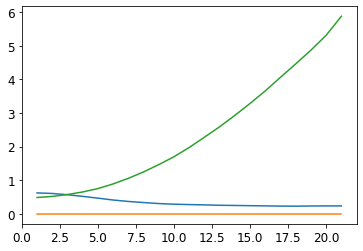

In [49]:
plt.plot(self.condY_x, condY_para[:, 0])
plt.plot(self.condY_x, condY_para[:, 1])
plt.plot(self.condY_x, condY_para[:, 2])
plt.show()

In [23]:
beta = std_norm.ppf(1 - 1/self.x_pd.c_rate/MRP)

# MRP of independent Y for validation
y_mrp = self.y_pd.predict(MRP=MRP)

# Jagged contour
condY_F = get_condY_F(self.x_pd, beta, self.condY_x)
contour_jag_top = get_jaggaed_contour(self.condY_pd, condY_F)
contour_jag_bot = get_jaggaed_contour(self.condY_pd, 1 - condY_F)

# Determine range of re-parameterization

# Upper contour
condY_F = get_condY_F(self.x_pd, beta, self.x_pd.sample_coor)

# Lower contour

# Combine result

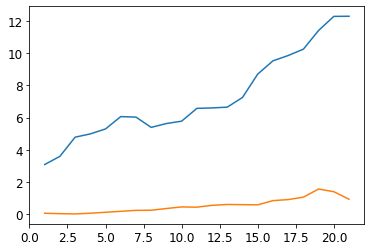

In [11]:
plt.plot(self.condY_x, contour_jag_top)
plt.plot(self.condY_x, contour_jag_bot)
plt.show()

In [5]:
for dist_name in [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]:
    print(f'{dist_name}: {getattr(stats, dist_name).numargs}')

alpha: 1
anglit: 0
arcsine: 0
argus: 1
beta: 2
betaprime: 2
bradford: 1
burr: 2
burr12: 2
cauchy: 0
chi: 1
chi2: 1
cosine: 0
crystalball: 2
dgamma: 1
dweibull: 1
erlang: 1
expon: 0
exponnorm: 1
exponpow: 1
exponweib: 2
f: 2
fatiguelife: 1
fisk: 1
foldcauchy: 1
foldnorm: 1
frechet_l: 1
frechet_r: 1
gamma: 1
gausshyper: 4
genexpon: 3
genextreme: 1
gengamma: 2
genhalflogistic: 1
genlogistic: 1
gennorm: 1
genpareto: 1
gilbrat: 0
gompertz: 1
gumbel_l: 0
gumbel_r: 0
halfcauchy: 0
halfgennorm: 1
halflogistic: 0
halfnorm: 0
hypsecant: 0
invgamma: 1
invgauss: 1
invweibull: 1
johnsonsb: 2
johnsonsu: 2
kappa3: 1
kappa4: 2
ksone: 1
kstwobign: 0
laplace: 0
levy: 0
levy_l: 0
levy_stable: 2
loggamma: 1
logistic: 0
loglaplace: 1
lognorm: 1
lomax: 1
maxwell: 0
mielke: 2
moyal: 0
nakagami: 1
ncf: 3
nct: 2
ncx2: 2
norm: 0
norminvgauss: 2
pareto: 1
pearson3: 1
powerlaw: 1
powerlognorm: 2
powernorm: 1
rayleigh: 0
rdist: 1
recipinvgauss: 1
reciprocal: 2
rice: 1
semicircular: 0
skewnorm: 1
t: 1
trapz: 2
tria